## Dependencies and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Cleaning

In [3]:
loans.columns = loans.columns.str.strip()
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


## Exploration

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4269 non-null   int64
 1   education                 4269 non-null   int64
 2   self_employed             4269 non-null   int64
 3   income_annum              4269 non-null   int64
 4   loan_amount               4269 non-null   int64
 5   loan_term                 4269 non-null   int64
 6   residential_assets_value  4269 non-null   int64
 7   commercial_assets_value   4269 non-null   int64
 8   luxury_assets_value       4269 non-null   int64
 9   bank_asset_value          4269 non-null   int64
 10  loan_status               4269 non-null   int64
dtypes: int64(11)
memory usage: 367.0 KB


In [5]:
loans.describe().applymap("{:,.1f}".format)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,"4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0"
mean,2.5,0.5,0.5,"5,059,123.9","15,133,450.5",10.9,"7,472,616.5","4,973,155.3","15,126,305.9","4,976,692.4",0.6
std,1.7,0.5,0.5,"2,806,839.8","9,043,363.0",5.7,"6,503,636.6","4,388,966.1","9,103,753.7","3,250,185.3",0.5
min,0.0,0.0,0.0,"200,000.0","300,000.0",2.0,"-100,000.0",0.0,"300,000.0",0.0,0.0
25%,1.0,0.0,0.0,"2,700,000.0","7,700,000.0",6.0,"2,200,000.0","1,300,000.0","7,500,000.0","2,300,000.0",0.0
50%,3.0,1.0,1.0,"5,100,000.0","14,500,000.0",10.0,"5,600,000.0","3,700,000.0","14,600,000.0","4,600,000.0",1.0
75%,4.0,1.0,1.0,"7,500,000.0","21,500,000.0",16.0,"11,300,000.0","7,600,000.0","21,700,000.0","7,100,000.0",1.0
max,5.0,1.0,1.0,"9,900,000.0","39,500,000.0",20.0,"29,100,000.0","19,400,000.0","39,200,000.0","14,700,000.0",1.0


In [6]:
loans.nunique()

no_of_dependents              6
education                     2
self_employed                 2
income_annum                 98
loan_amount                 378
loan_term                    10
residential_assets_value    278
commercial_assets_value     188
luxury_assets_value         379
bank_asset_value            146
loan_status                   2
dtype: int64

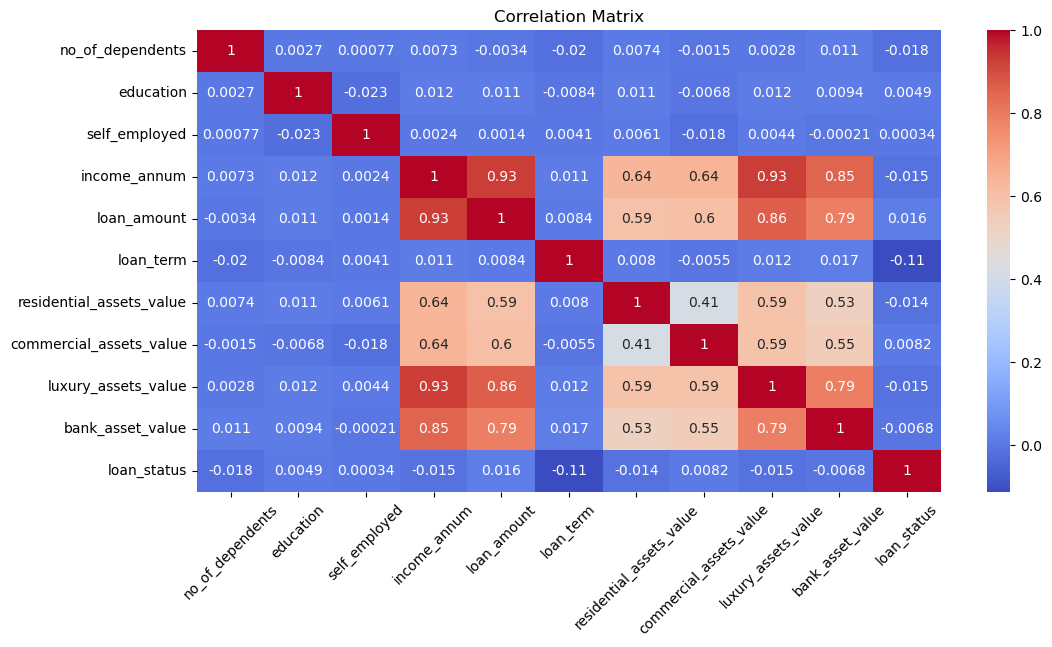

In [7]:
corr_matrix = loans.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

## Initial model testing

In [11]:
X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1234, test_size=0.3)

# Comparing accuracies
accs = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0}

In [12]:
knn = KNeighborsClassifier(n_neighbors=7)
accs["knn"] = cross_val_score(knn, X_train, y_train).mean()

In [13]:
lr = LogisticRegression(random_state=1234)
accs["lr"] = cross_val_score(lr, X_train, y_train).mean()

In [14]:
dtc = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)
accs["dtc"] = cross_val_score(dtc, X_train, y_train).mean()

In [15]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1234)
accs["rfc"] = cross_val_score(rfc, X_train, y_train).mean()

In [16]:
svc = SVC(kernel="linear")
accs["svc"] = cross_val_score(svc, X_train, y_train).mean()

In [17]:
mlp = MLPClassifier(activation='identity', solver='sgd', random_state=1234)
accs["mlp"] = cross_val_score(mlp, X_train, y_train).mean()

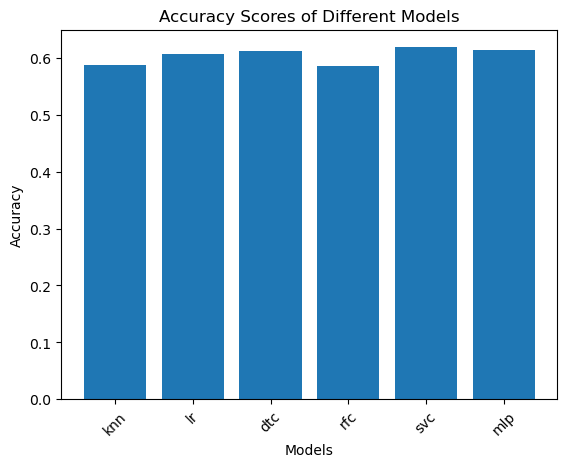

In [18]:
# Assuming you have a list of accuracy scores called accuracy_scores
accuracy_scores = accs.values()

# Create a list of corresponding x-axis values
x_values = range(len(accuracy_scores))

# Plot the bar graph
plt.bar(x_values, accuracy_scores)

# Add labels to the plot
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')

# Customize the x-axis tick labels if necessary
plt.xticks(x_values, accs.keys(), rotation=45)

# Display the plot
plt.show()

### Todo
- balancing
- feature selection
- dimensionality reduction
- hyperparameter tuning